Function to load data to the variable data_frame

In [4]:
#@title Load data to variable
import csv

def load_data(file_directory):

    data_frame = []

    with open(file_directory) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
#        next(csv_reader)
        for row in csv_reader:
            data_frame.append(row)

    return data_frame

In [5]:
#@title Import data file from Google Drive
from google.colab import drive

drive.mount('/content/drive')

file_name = "data-01000-00500-abcd.csv" #@param {type:"raw"}
file_directory = "/content/drive/MyDrive/BlockingNotebook/" + file_name

data_frame = load_data(file_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load csv file generated by the data generator function
Need to mount drive to access these files, can change it in the future to run data generator and blocking notebook together in the future

In [6]:
#@title Load blocking algorithms from Github repo
!git clone https://github.com/BruceMD/MPIBlockingNotebook.git

Cloning into 'MPIBlockingNotebook'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


Load .py files for the various blocking algorithms to import and implement

In [7]:
#@title Change working directory
import sys
import os

py_file_location = "/content/MPIBlockingNotebook" #@param {type:"raw"}
sys.path.append(os.path.abspath(py_file_location))

In [8]:
#@title Import blocking libraries and algorithms
!pip install phonetics
!pip install fastDamerauLevenshtein
!pip install textdistance

import compare_soundex
import compare_metaphone
import compare_double_metaphone
import compare_levenshtein
import compare_damerau_levenshtein
import compare_jaro_winkler
import compare_jaccard_similarity
import compare_exact_match

  Created wheel for phonetics: filename=phonetics-1.0.5-py2.py3-none-any.whl size=8713 sha256=6fa48987e2f62e1293958a1010dcf87bfbb91ad82291040a058301fdd63a79f9
  Stored in directory: /root/.cache/pip/wheels/c2/c9/f4/5f43d3212d0aece0feced2484127ddb227ae43d57102aeb259
Successfully built phonetics
  Created wheel for fastDamerauLevenshtein: filename=fastDamerauLevenshtein-1.0.7-cp37-cp37m-linux_x86_64.whl size=59399 sha256=a95f20b888598c3f5bafce5552a8cceb1029555cc23cdc89e3ac31ee562ac0f4
  Stored in directory: /root/.cache/pip/wheels/3d/f6/ac/23a63dea60e40b449efa973a54f5b1ba766a984be2d7b95964
Successfully built fastDamerauLevenshtein


Checkbox(
    value=False,
    description='Check me',
    disabled=False,
    indent=False
)

Dropdown(
    options=["Exact Match", "Jaro-Winkler Similarity", "Levenshtein Edit Distance", "Damerau-Levenshtein Edit Distance", "Jaccard Similarity", "SoundEx", "Metaphone", "Double Metaphone"],
    description='Algorithms:',
    disabled=False,
)

In [9]:
from ipywidgets import HBox, VBox, Checkbox, Dropdown, Button
from IPython.display import display

columns = data_frame[0][1:]

check_boxes = [Checkbox(description=c, value=False, disabled=False, indent=False) for c in columns]

algorithms1 = [Dropdown(options=["None", "Exact Match", "Jaro-Winkler Similarity", "Levenshtein Edit Distance", "Damerau-Levenshtein Edit Distance", "Jaccard Similarity", "SoundEx", "Metaphone", "Double Metaphone"],
    value="None",
    disabled=check.value) for check in check_boxes]
algorithms2 = [Dropdown(options=["None", "Exact Match", "Jaro-Winkler Similarity", "Levenshtein Edit Distance", "Damerau-Levenshtein Edit Distance", "Jaccard Similarity", "SoundEx", "Metaphone", "Double Metaphone"],
    value="None",
    disabled=check.value) for check in check_boxes]
algorithms3 = [Dropdown(options=["None", "Exact Match", "Jaro-Winkler Similarity", "Levenshtein Edit Distance", "Damerau-Levenshtein Edit Distance", "Jaccard Similarity", "SoundEx", "Metaphone", "Double Metaphone"],
    value="None",
    disabled=check.value) for check in check_boxes]
algorithms4 = [Dropdown(options=["None", "Exact Match", "Jaro-Winkler Similarity", "Levenshtein Edit Distance", "Damerau-Levenshtein Edit Distance", "Jaccard Similarity", "SoundEx", "Metaphone", "Double Metaphone"],
    value="None",
    disabled=check.value) for check in check_boxes]

column = VBox(check_boxes)
algorithm1 = VBox(algorithms1)
algorithm2 = VBox(algorithms2)
algorithm3 = VBox(algorithms3)
algorithm4 = VBox(algorithms4)


display(HBox([column, algorithm1, algorithm2, algorithm3, algorithm4]))

Basic table output for user to choose which columns they would like to block on using which algorithms

Level of each blocking (edit ditance and similarity) to be included at a later stage.

In [20]:
col_func = {}
unique_algorithm = set()

for i in range(11):
    if check_boxes[i].value:
        temp_list = []
        for alg in [algorithms1, algorithms2, algorithms3, algorithms4]:
            if alg[i].value != "None":
                temp_list.append(alg[i].value)
                unique_algorithm.add(alg[i].value)
        col_func[check_boxes[i].description] = temp_list

for key, value in col_func.items():
    print(key, value)

name ['Damerau-Levenshtein Edit Distance']
gender ['Levenshtein Edit Distance']
dob ['Exact Match']


In [21]:
from ipywidgets import IntSlider, FloatSlider, HBox, VBox, Label

jw_slider = FloatSlider(value=0.85, 
                        min=0, 
                        max=1, 
                        step=0.05,
                        description="Jaro-Winkler Similarity level",  
                        disabled="Jaro-Winkler Similarity" not in unique_algorithm)

l_slider = IntSlider(value=2, 
                     min=0, 
                     max=5, 
                     step=1, 
                     description="Levenshtein Edit Distance level",
                     disabled="Levenshtein Edit Distance" not in unique_algorithm)

dl_slider = IntSlider(value=2, 
                      min=0, 
                      max=5, 
                      step=1, 
                      description="Damerau-Levenshtein Edit Distance level",
                      disabled="Damerau-Levenshtein Edit Distance" not in unique_algorithm)
j_slider = FloatSlider(value=0.85, 
                       min=0, 
                       max=1, 
                       step=0.05, 
                       description="Jaccard Similarity Level",
                       disabled="Jaccard Similarity" not in unique_algorithm)

display(l_slider)
display(dl_slider)
display(jw_slider)
display(j_slider)

IntSlider(value=2, description='Levenshtein Edit Distance level', max=5)

IntSlider(value=2, description='Damerau-Levenshtein Edit Distance level', max=5)

FloatSlider(value=0.85, description='Jaro-Winkler Similarity level', disabled=True, max=1.0, step=0.05)

FloatSlider(value=0.85, description='Jaccard Similarity Level', disabled=True, max=1.0, step=0.05)

Extract the columns the user would like to test using the algorithms they have selected

In [28]:
def blocking(rec1, rec2, criteria):

    true_count = 0

    for name, algorithms in criteria.items():
        for alg in algorithms:
            result = implement(rec1[column_identity(name)], rec2[column_identity(name)], alg)
            if result:
                true_count += 1
                break

    return true_count >= len(criteria) - 1


def implement(field1, field2, algorithm):

#    print("Testing {} against {} using algorithm: {}".format(field1, field2, algorithm))

    if algorithm == "Exact Match":
        return compare_exact_match.compare(field1, field2)
    elif algorithm == "Jaro-Winkler Similarity":
        return compare_jaro_winkler.compare(field1, field2, jw_slider.value)
    elif algorithm == "Levenshtein Edit Distance":
        return compare_levenshtein.compare(field1, field2, l_slider.value)
    elif algorithm == "Damerau-Levenshtein Edit Distance":
        return compare_damerau_levenshtein.compare(field1, field2, dl_slider.value)
    elif algorithm == "Jaccard Similarity":
        return compare_jaccard_similarity.compare(field1, field2, j_slider.value)
    elif algorithm == "SoundEx":
        return compare_soundex.compare(field1, field2)
    elif algorithm == "Metaphone":
        return compare_metaphone.compare(field1, field2)
    elif algorithm == "Double Metaphone":
        return compare_double_metaphone.compare(field1, field2)
    else:
        return None


def missing_data(rec1, rec2, columns):

    for key in columns.keys():
        if not rec1[column_identity(key)] or not rec2[column_identity(key)]:
            return True
    return False


def column_identity(name):

    for ind, col_name in enumerate(columns):
        if col_name == name:
            return ind + 1


#blocking(data_frame[4], data_frame[7], col_func)

blocking(rec1, rec2, criteria) compares two records using the criteria set in the Ipywidgets table of columns and algorithms
From there it returns true or false for a probable **match**

In [36]:
#@title Result summaries
from IPython.display import HTML, display
import tabulate


def print_summary(runtime):

    print("Blocking on the data from file {} with {} records using the following columns and algorithms:".format(file_name, len(data_frame)-1))
    for key, value in col_func.items():
        print("{}: {}".format(key, value))
    print("This method identified {} True Positive matches with a further {} positive matches in the missing data inclusion.".format(true_pos, missing_pos))
    print("{} False Negative matches and {} False Positive matches produce a recall rate of {} and precision of {}".format(false_neg, false_pos, (true_pos + missing_pos) / (true_pos + missing_pos + false_neg), (true_pos + missing_pos) / (true_pos + missing_pos + false_pos)))
    print("{} matches were excluded out of the {} total matches, providing a blocking efficiency of {}".format(false_neg + true_neg, total_matches, (false_neg + true_neg) / total_matches))
    print("Runtime = {}".format(runtime))


def print_summary_table(runtime):
    data = [["Total matches", total_matches],
            ["Matches excluded", false_neg + true_neg],
            ["Missing data inclusions", total_missing],
            ["Missing data positives", missing_pos],
            ["Algorithm positives", true_pos],
            ["Total true positives", true_pos + missing_pos],   
            ["False negatives", false_neg],
            ["False positives", false_pos],
            ["Recall", (true_pos + missing_pos) / (true_pos + missing_pos + false_neg)],
            ["Precision", (true_pos + missing_pos) / (true_pos + missing_pos + false_pos)],
            ["Blocking efficiency", (true_neg + false_neg) / total_matches],
            ["Runtime", runtime]]
    display(HTML(tabulate.tabulate(data, tablefmt='html')))


In [24]:
from time import time
from tqdm.notebook import tqdm


start_time = time()

true_pos, false_neg, false_pos, true_neg = 0, 0, 0, 0
total_matches = 0
total_missing, missing_pos= 0, 0

for i in tqdm(range(1, len(data_frame))):
    for j in range(i+1, len(data_frame)):
        total_matches += 1
        match_bool = blocking(data_frame[i], data_frame[j], col_func)
        if match_bool:
            if data_frame[i][0][:12] == data_frame[j][0][:12]:
                true_pos += 1
            else:
                false_pos += 1
        elif missing_data(data_frame[i], data_frame[j], col_func):
            total_missing += 1
            if data_frame[i][0][:12] == data_frame[j][0][:12]:
                missing_pos += 1
            else:
                false_pos += 1
        else:
            if data_frame[i][0][:12] == data_frame[j][0][:12]:
                false_neg += 1
            else:
                true_neg += 1

end_time = time()

In [37]:
#@title Display results in paragraph format
print_summary(end_time - start_time)

Blocking on the data from file data-01000-00500-abcd.csv with 1500 records using the following columns and algorithms:
name: ['Damerau-Levenshtein Edit Distance']
gender: ['Levenshtein Edit Distance']
dob: ['Exact Match']
This method identified 617 True Positive matches with a further 32 positive matches in the missing data inclusion.
2 False Negative matches and 209521 False Positive matches produce a recall rate of 0.9969278033794163 and precision of 0.0030879764000570965
914080 matches were excluded out of the 1124250 total matches, providing a blocking efficiency of 0.8130575939515232
Runtime = 31.55028247833252


In [38]:
#@title Display results in table
print_summary_table(end_time - start_time)

Total matches,1.12425e+06
Matches excluded,914080
Missing data inclusions,201179
Missing data positives,32
Algorithm positives,617
Total true positives,649
False negatives,2
False positives,209521
Recall,0.996928
Precision,0.00308798
Blocking efficiency,0.813058


Text(0.5, 1.0, 'Pie charts showing Recall, Precision and Blocking Efficiency')

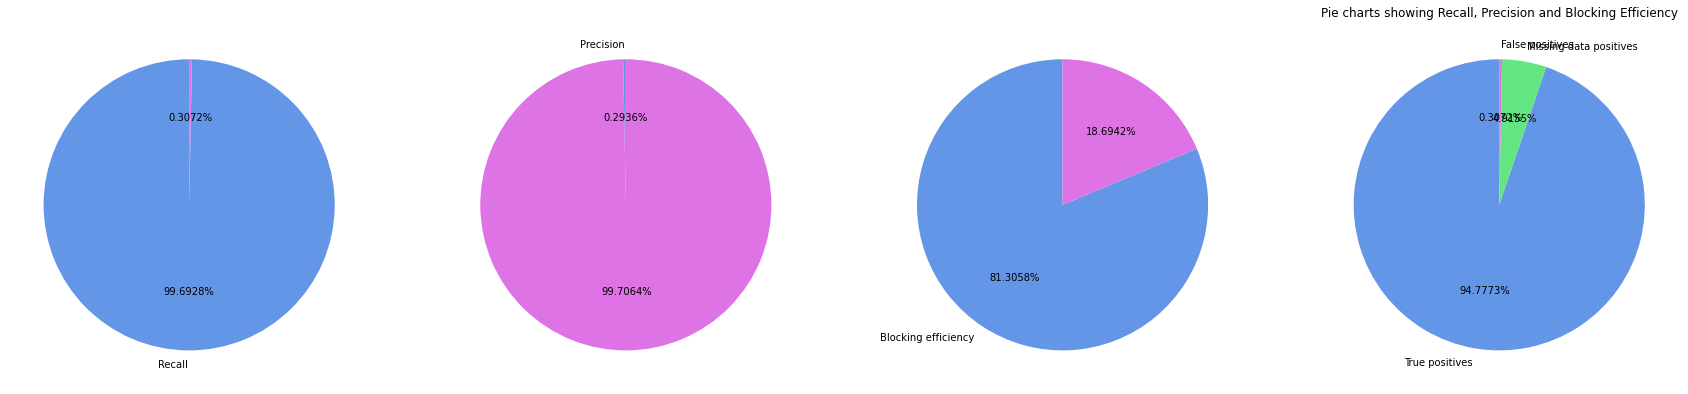

In [29]:
#@title Display results in pie charts using matplotlib
import matplotlib.pyplot as plt

recall = (true_pos + missing_pos) / (true_pos + missing_pos + false_neg)
recall_labels = ["Recall", " "]
recall_sections = [recall, 1 - recall]


precision = true_pos / (true_pos + false_pos + missing_pos)
prec_labels = ["Precision", " "]
prec_sections = [precision, 1 - precision]

blocking_efficiency = (true_neg + false_neg) / total_matches 
be_labels = ["Blocking efficiency", " "]
be_sections = [blocking_efficiency, 1 - blocking_efficiency]

positives = [true_pos]
pos_labels = ["True positives"]
if missing_pos:
    positives.append(missing_pos)
    pos_labels.append("Missing data positives")
if false_neg:
    positives.append(false_neg)
    pos_labels.append("False positives")

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 10))
colors = ["#6396e6", "#de73e6"]


axes[0].pie(recall_sections, 
        labels=recall_labels, 
        colors=colors, 
        startangle=90,
        autopct='%1.4f%%')
axes[1].pie(prec_sections, 
        labels=prec_labels, 
        colors=colors,
        startangle=90, 
        autopct='%1.4f%%')
axes[2].pie(be_sections, 
        labels=be_labels, 
        colors=colors, 
        startangle=90, 
        autopct='%1.4f%%')
axes[3].pie(positives, 
            labels=pos_labels, 
            colors=["#6396e6","#63e581", "#de73e6"], 
            startangle=90,
            autopct='%1.4f%%')

plt.title("Pie charts showing Recall, Precision and Blocking Efficiency")